<a href="https://colab.research.google.com/github/EiffL/Tutorials/blob/master/InverseProblems/DeepInverseProblemsTutorial_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021-2023 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");


# Introduction to Differentiable Programming and Deep Learning Priors in Jax

Author:
 - [@EiffL](https://github.com/EiffL) (Fancois Lanusse)

## Overview

The overall **aim of this tutorial is to solve image inverse problem (denoising, deconvolution, inpainting) in a fully Bayesian way** i.e. drawing from a posterior distribution, and using a deep generative model as a prior.

More concretely, **we will consider a deconvolution problem** where one aims to recover a high quality image from a low resolution image degraded by an instrumental response. The following figure provides an illustration of the problem:

![](https://www.researchgate.net/profile/Alan-Heavens/publication/1910339/figure/fig1/AS:394636699947010@1471100129570/Illustration-of-the-forward-problem-The-upper-panels-show-how-the-original-galaxy-image.png)

What we will have access to is an observed galaxy on the right of the chain, and we will try to recover the high resolution image before PSF convolution.


We will use two datasets as the basis for this challenge:
- Galaxies from the Hubble Space Telescope COSMOS survey, described for instance [here](https://arxiv.org/pdf/1308.4982.pdf#page=24) under `REAL GALAXY DATASET`.
- Galaxies of the [HSC Survey](https://hsc-release.mtk.nao.ac.jp/doc/), taken with the ground-based Subaru telescope

This tutorial will be split into 2 parts:
- In this first part, we will be discovering the datasets and tools needed for forward modeling.
- In the second part, we will be use generative modeling to solve this inverse problem.

### Learning objectives

Through this tutorial, you will put into practice the following concepts:

  - Build a forward model using Jax
  - Build a likelihood using TensorFlow Probability
  - Use a generative model to impose a data-driven prior
  - Retrieve maximum likelihood and a posterior solutions by optimization
  - Retrieve full posterior distributions by variational inference

## Installing dependencies and accessing data

In [ ]:
!pip install git+https://github.com/EiffL/Quarks2CosmosDataChallenge.git ChainConsumer
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse
!mkdir galsim

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [2]:
# Authenticating and mounting cloud data storage
from google.colab import auth
auth.authenticate_user()
!gcsfuse --implicit-dirs galsim galsim

I0919 13:10:11.954084 2023/09/19 13:10:11.954047 Start gcsfuse/1.1.0 (Go version go1.20.5) for app "" using mount point: /content/galsim


## Before we begin... A few words about JAX

What's the best Deep Learning framework? TensorFlow? PyTorch? Wrong: all you ever want is JAX :-)

![](https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png)

JAX = NumPy + autograd + XLA

In other words, it looks like pure NumPy, but is automatically differentiable, and runs on XLA (i.e. GPU accelerated). Checkout the [full documentation](https://jax.readthedocs.io/en/latest/index.html) to discover the many awesome features JAX has to offer.

#### Autodiff

For our purposes, the most interesting feature of JAX will be automatic differentiation, which is performed using `jax.grad`

In [3]:
%pylab inline
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Let's build a function of x that returns a scalar
def f(x):
    y = 2*x+1
    return y

In [5]:
# To get the derivative of this function, I simply use jax.grad
df_dx = jax.grad(f)

In [6]:
df_dx

<function __main__.f(x)>

`jax.grad` has *transformed* my function `f` into a new function that comptutes its gradient.

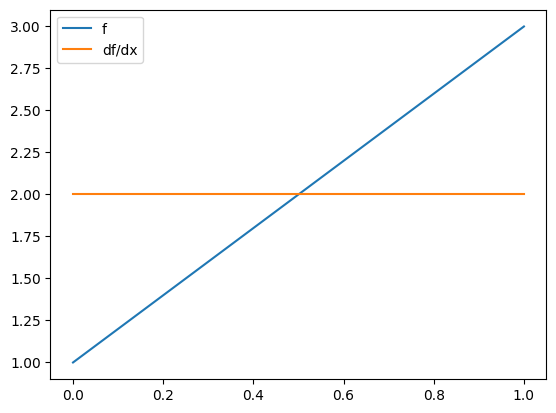

In [7]:
u = jnp.linspace(0,1)
plot(u, f(u), label='f')
plot(u,jax.vmap(df_dx)(u), label='df/dx')
legend()

#### Vectorization with `vmap`

Another awesome feature of JAX is the ability to batch any function using the `jax.vmap` transformation. Say you have a function that works on a single example:

In [8]:
def f(x):
    # Expect x to be of shape [16, 16]
    nx, ny = x.shape
    x = x + jnp.ones([nx,ny])
    return x

In [9]:
x = jnp.zeros([16,16])
f(x).shape

(16, 16)

In [ ]:
# But this function wouldn't work if I had a batch of images
x = jnp.zeros([1,16,16])
f(x).shape # THIS SHOULD FAIL

In [11]:
# But I can use jax magic
f_batched = jax.vmap(f)

x = jnp.zeros([1,16,16])
f_batched(x).shape

(1, 16, 16)

Tada!

#### JIT compilation

The final super useful thing to know about JAX is that you can JIT (Just In Time) compile any function, they will be compiled as an XLA graph and completely bypass Python to run directly under XLA.

In [12]:
def f(x, A):
    return A.dot(x)

f_jitted = jax.jit(f)

In [13]:
x = randn(128)
A = randn(128,128)

In [14]:
f_jitted(x,A);

On this example, jitting won't make much of a difference because it is  a tiny function, but we will see later that we can JIT the computation of the loss and update of a full neural network, which then becomes lightning fast.

## Step I: Loading the data

In this section, we load the datasets for our space-based and ground-based images. Both datasets are conviently accessible as [TensorFlow Datasets](https://www.tensorflow.org/datasets) datasets, you simply need the following imports to access them:

In [15]:
import quarks2cosmos.datasets
import tensorflow_datasets as tfds

#### COSMOS Dataset

The COSMOS dataset is built from the GalSim COSMOS sample (see [here](https://galsim-developers.github.io/GalSim/_build/html/real_gal.html) for details), it contains postage stamps of real galaxies,  **convolved with an isotropized HST PSF** which is the same for all galaxies. These images are thus completely standardized, and the PSF doesn't vary from one object to the other.

Properties of COSMOS stamps:
- TRAIN and TEST splits with 40000 and 10000 images respectively
- Constant isotropic PSF
- Pixel scale 0.03
- Postage stamp size: 101x101

In [32]:
dset_cosmos = tfds.load("Cosmos/23.5", split=tfds.Split.TRAIN,
                        data_dir='galsim/tensorflow_datasets') # Load the TRAIN split
dset_cosmos = dset_cosmos.as_numpy_iterator()                  # Convert the dataset to numpy iterator

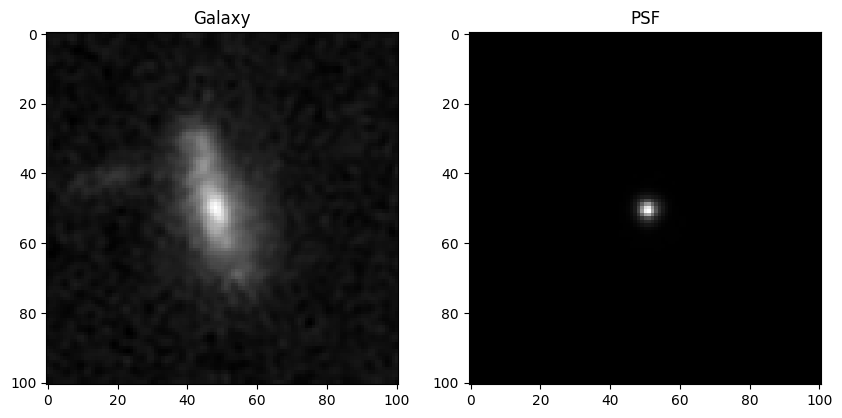

In [33]:
# Extract a new example from the dataset
cosmos = next(dset_cosmos)
cosmos = next(dset_cosmos)

figure(figsize=[10,5])
subplot(121)
imshow(cosmos['image'],cmap='gray')
title('Galaxy')
subplot(122)
imshow(cosmos['psf'],cmap='gray')
title('PSF');

#### HSC Dataset

The HSC galaxies are drawn from the PDR2 data release and extracted using the excellent [unagi](https://github.com/dr-guangtou/unagi) tool. Details of how these objects are selected can be found in this accompanying [notebook](HSCDataPreparation.ipynb), but essentially these are i-band stamps of galaxies with imag $\in [21, 23.5]$, also verifying the `forced.i_pixelflags_interpolatedcenter` condition, meaning they contain a number of interpolated pixels which intersect the center of the object. The stamps are at resolution 0.168 arcsec, and the PSF is provided for each galaxy.

Properties of HSC stamps:
- Single TRAIN split of ~10000 examples
- PSF, pixel masks, and variance map provided for every image
- Pixel scale: 0.168
- Postage stamp size: 41x41

In [34]:
dset_hsc = tfds.load("HSC", split=tfds.Split.TRAIN,
                     data_dir='galsim/tensorflow_datasets')
dset_hsc = dset_hsc.as_numpy_iterator()

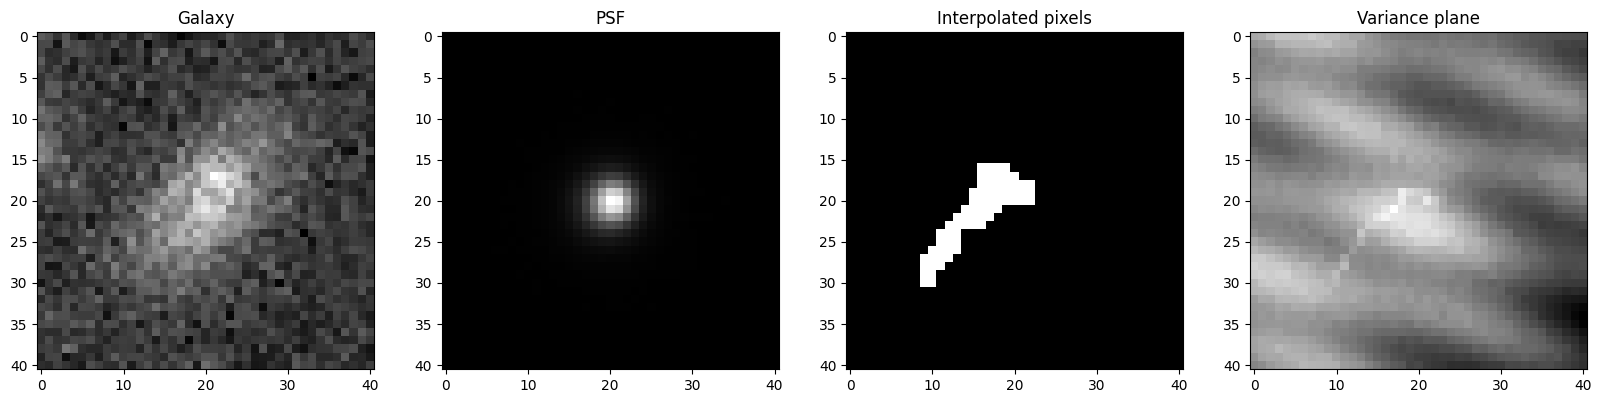

In [35]:
# Extract a new example from the dataset
hsc = next(dset_hsc)

figure(figsize=[20,5])
subplot(141)
imshow(hsc['image'],cmap='gray')
title('Galaxy')
subplot(142)
imshow(hsc['psf'],cmap='gray')
title('PSF')
subplot(143)
imshow(hsc['mask'] == 44,cmap='gray')
title('Interpolated pixels')
subplot(144)
imshow(hsc['variance'],cmap='gray')
title('Variance plane');

## Step II: Building a forward model



We only provides the fundamentals here, and we encourage the interested reader to directly reach out to the tutorial organizers to learn more :-)

The problems we will be addressing in this tutorial can be written as the following:

$$y = \Pi \ast \left(  \mathbf{P} \ (\Pi_{HST}^{-1} \ast x ) \right) + n \qquad \mbox{with} \qquad n \sim \mathcal{N}(0, \sigma^2)$$
where $y$ are the measurements and where:
- $x$ would be a space-based HST galaxy image we would like to recover
- $\Pi_{HST}$ is the HST PSF
- $\mathbf{P}$ is a resampling operator to go from the pixel scale of HST to that of HSC images
- $\Pi$ is a given HSC PSF
- $\sigma$ is the noise variance of HSC observations.  

Typically, one would use the [GalSim software](https://github.com/GalSim-developers/GalSim) to perform these manipulations (convolution/deconvolution/resampling) but GalSim is not differentiable :-(

For the purpose of this data challenge we provide JAX equivalent functions as part of the `quarks2cosmos.galjax` and this will allow us to write a differentiable forward model:

In [36]:
from quarks2cosmos import galjax as gj

In [37]:
def simulate_hsc(x, in_psf, out_psf):
    """ This function will simulate an image at HSC resolution given an image at HST resolution,
    accounting for input PSF and convolving by output PSF
    Args:
        x: HST resolution image (MUST BE ODD SIZE!!!!)
        in_psf: HST PSF
        out_psf: HSC PSF
    Returns:
        y: HSC simulated image of size [41,41]
    """
    y = gj.deconvolve(x, in_psf)         # Deconvolve by input PSF
    y = gj.kresample(y, 0.03, 0.168, 41) # Resample image to HSC grid
    y = gj.convolve(y,  out_psf)         # Reconvolve by HSC PSF
    return 2.587*y                       # Conversion factor for the flux

In [38]:
# Let's apply it to our input images
im = simulate_hsc(cosmos['image'], cosmos['psf'], hsc['psf'])

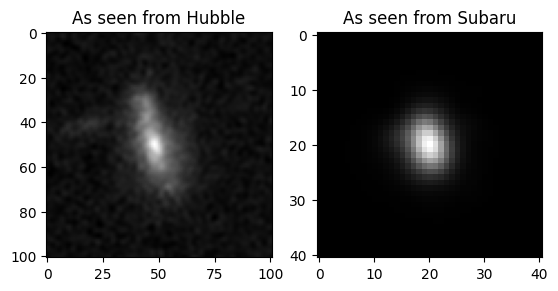

In [39]:
subplot(121)
imshow(cosmos['image'], cmap='gray')
title('As seen from Hubble')
subplot(122)
imshow(im, cmap='gray')
title('As seen from Subaru');

So far our model only generates an HSC image without noise, but we are provided with a noise variance map for each observation, so we can actually write down a likelihood function.

#### Data likelihood using TensorFlow Probability

This is an opportunity to introduce the awesome [TensorFlow Probabilty](https://www.tensorflow.org/probability) package, which also works with JAX ;-) with the following imports:

In [40]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

As mentioned in the model above, we assume a Gaussian likelihood for the observations:

$$ p(y | x) = \mathcal{N}(y ; f(x), \Sigma) $$

where $f$ is our forward model defined above, and $\Sigma$ is our noise covariance, which we assume diagonal here. In TFP, we can create this likelihood very easily as:

In [41]:
likelihood = tfd.Independent(tfd.Normal(loc=simulate_hsc(cosmos['image'], cosmos['psf'], hsc['psf']),
                                        scale=jnp.sqrt(hsc['variance'])),
                             reinterpreted_batch_ndims=2) # This is to make sure TFP understand we have a 2d image

In [42]:
likelihood

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[41, 41] dtype=float32>

Once you have this likelihood, you can for instance sample from it:

In [43]:
im_noise = likelihood.sample(seed=jax.random.PRNGKey(1))

Text(0.5, 1.0, 'As seen from Subaru + Noise')

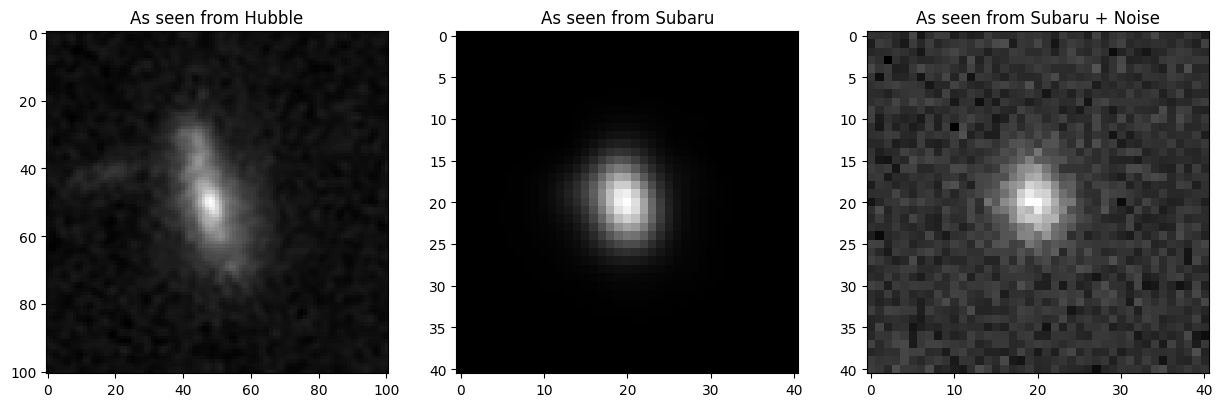

In [44]:
figure(figsize=[15,5])
subplot(131)
imshow(cosmos['image'], cmap='gray')
title('As seen from Hubble')
subplot(132)
imshow(im, cmap='gray')
title('As seen from Subaru')
subplot(133)
imshow(im_noise, cmap='gray')
title('As seen from Subaru + Noise')

Or evaluate the likelihood at any given point:

In [45]:
likelihood.log_prob(im_noise)

Array(1602.9819, dtype=float32)

## Step III: Solving an inverse problem by optimization

Now that we have the ability to write a forward model and evaluate a likelihood, we can get started on trying to solve our inverse problem.

We will start by trying to recover a maximum likelihood solution
$$ \hat{x} = \arg \max_{x} \log p(y | x) $$

Let's simulate some observations that will act as our observables $y$ and for which we will know the truth:

In [46]:
# Let's make sure we use the correct image for the rest of this tutorial
dset_cosmos = tfds.load("Cosmos/23.5", split=tfds.Split.TRAIN,
                        data_dir='galsim/tensorflow_datasets').as_numpy_iterator()
cosmos = [next(dset_cosmos) for i in range(2)][-1]

# We will use this new galaxy as are reference here
x_true = cosmos['image']
# And we apply the same logic as above to create a sample from the corresponding HSC likelihood
y_obs = tfd.Independent(tfd.Normal(loc=simulate_hsc(cosmos['image'], cosmos['psf'], hsc['psf']),
                                    scale=jnp.sqrt(hsc['variance'])),
                             reinterpreted_batch_ndims=2).sample(seed=jax.random.PRNGKey(1))

Text(0.5, 1.0, 'Observed image')

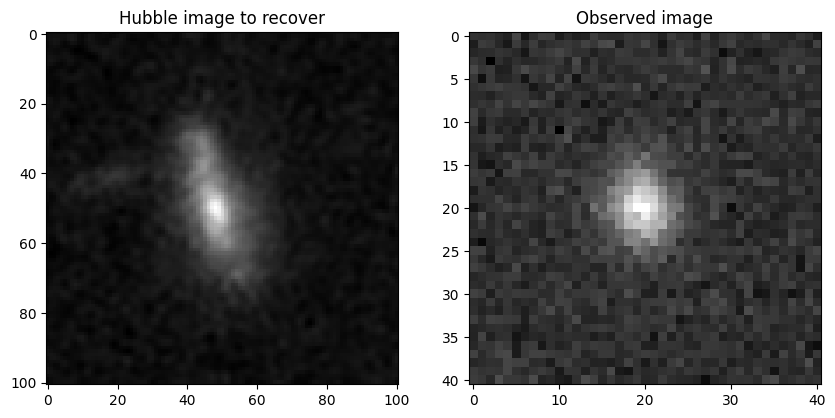

In [47]:
figure(figsize=[10,5])
subplot(121)
imshow(x_true, cmap='gray')
title('Hubble image to recover')
subplot(122)
imshow(y_obs, cmap='gray')
title('Observed image')

#### Writing a log likelihood function

In [48]:
def log_prob(x):
    """ Returns the value of the log likelihood of the observed data for a give x
    """
    likelihood = tfd.Independent(tfd.Normal(loc=simulate_hsc(x, cosmos['psf'], hsc['psf']),
                                            scale=jnp.sqrt(hsc['variance'])),
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(y_obs)

#### Creating an optimizer
Once we have a likelihood, we now want to optimize it, for this we will use the optax library:

In [49]:
import optax

optimizer = optax.adam(0.01) # Instantiate an ADAM optimizer

# Create a variable to store the solution
x = jnp.zeros([101, 101])

# Initialize the optimizer
opt_state = optimizer.init(x)

#### Writing an update function

The way optax and most JAX neural network libraries work is that the optimizer provides a function that computes how to update the parameters given the gradients of the loss function. One iteration of the optimization will look like this:

In [50]:
@jax.jit
def update(x, opt_state):
    """ Computes update to parameters x
    """
    logp, grads = jax.value_and_grad(log_prob)(x)              # Takes the gradients of the likelihood
    updates, opt_state = optimizer.update(-grads, opt_state)   # Computes ADAM update to maximize likelihood
    x = optax.apply_updates(x, updates)                        # Apply update to parameters
    return logp, x, opt_state

#### Running the optimization loop

In [51]:
losses = []

In [52]:
for i in range(200):
    logp, x, opt_state = update(x, opt_state)
    losses.append(logp)

Text(0.5, 0, 'step')

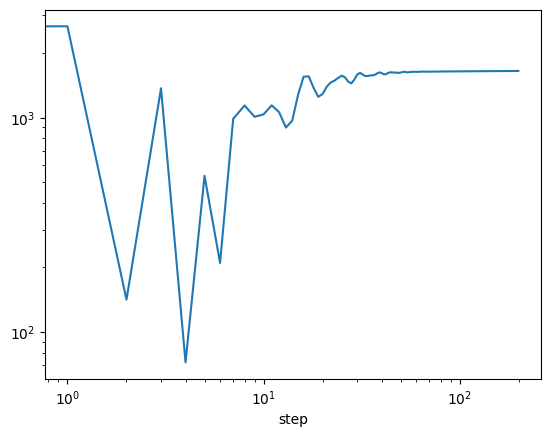

In [53]:
loglog(abs(jnp.array(losses)))
xlabel('step')

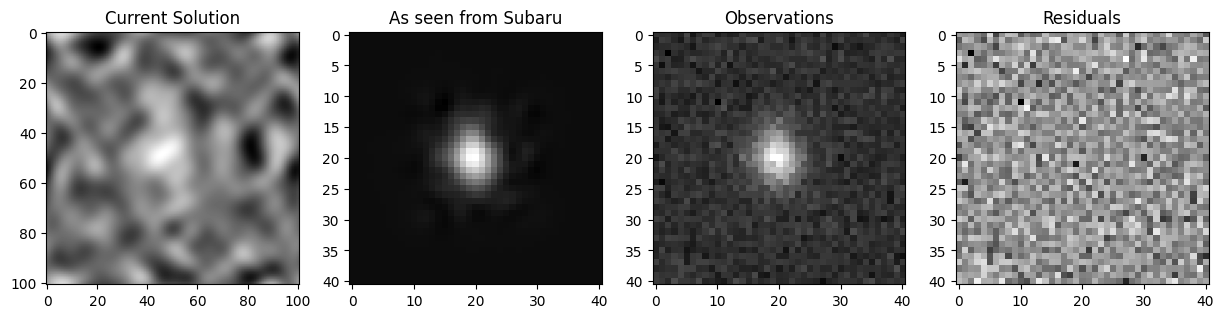

In [54]:
# Let's look at the solution!
figure(figsize=[15,5])
subplot(141)
imshow(x, cmap='gray')
title('Current Solution')
subplot(142)
imshow(simulate_hsc(x, cosmos['psf'], hsc['psf']), cmap='gray')
title('As seen from Subaru')
subplot(143)
imshow(y_obs, cmap='gray')
title('Observations')
subplot(144)
imshow(y_obs - simulate_hsc(x, cosmos['psf'], hsc['psf']), cmap='gray')
title('Residuals');

And there you have it, we have found **a** solution, which fits the observations very well! Now, is it a good solution? Given that the inverse problem is very ill-posed and that we have no prior, we get a solution that doesn't appear very physical.

## Step IV: Getting our hands on a Deep Generative Model

Now that we know how to build the forward model, we can work on building a good prior model for our problem.

The idea is to use a Deep Generative Model that would have been trained on images of space-based galaxies to act as our prior. For the purpose of this tutorial, we will use a **Variational Auto-Encoder** model that has been fitted to the COSMOS sample.

**Note**: The details of the architecture of this model are beyond the scope of this tutorial. We direct the interested reader to this notebook:
  - [Guided Data Challenge Part II: Generative Modeling](https://github.com/EiffL/Quarks2CosmosDataChallenge/blob/colab/notebooks/PartII-GenerativeModels.ipynb): Describes how to build and train the VAE on COSMOS data.


In [55]:
#@title Imports, useful functions, and parameter loading [Run me]

# Specific models built by EiffL
from quarks2cosmos.models.vae import Decoder
from quarks2cosmos.models.flow import AffineFlow
# Restore model parameters
import pickle
import haiku as hk

with open('/content/galsim/model-50000.pckl', 'rb') as file:
    params_vae, state_vae, _ = pickle.load(file)
with open('/content/galsim/model-20000.pckl', 'rb') as file:
    params_flow, _ = pickle.load(file)
params_generative_model = hk.data_structures.merge(params_vae, params_flow)

def generative_model_fn(z):
  """ Transforms a latent variable z into a morphology image.
  Inputs:
    z: a Normal variable of size [32]
  Outputs:
    x: an image of size [101,101] with pixels of 0.03 arcsec
  """
  z = jnp.atleast_2d(z).astype('float32')
  # Transform from Gaussian space to VAE latent space
  z1 = AffineFlow()().bijector.forward(z)
  # Decode sample with decoder
  likelihood = Decoder()(z1, is_training=False)
  # Return likelihood mean
  return likelihood.mean().squeeze()

gen_model_fn = hk.without_apply_rng(hk.transform_with_state(generative_model_fn))

generative_model = jax.jit(lambda z: gen_model_fn.apply(params_generative_model, state_vae, z)[0])

The generative model we will be using takes as an input a latent variable $z$ of size 32, and returns an image $x$ of size 101x101 with pixels of size 0.03 arcsec.

To sample from the model:

In [56]:
# Draw a random Normal
z = tfd.MultivariateNormalDiag(jnp.zeros(32), jnp.ones(32)).sample(9, seed=jax.random.PRNGKey(10))

# Run it through the forward model
x = generative_model(z)

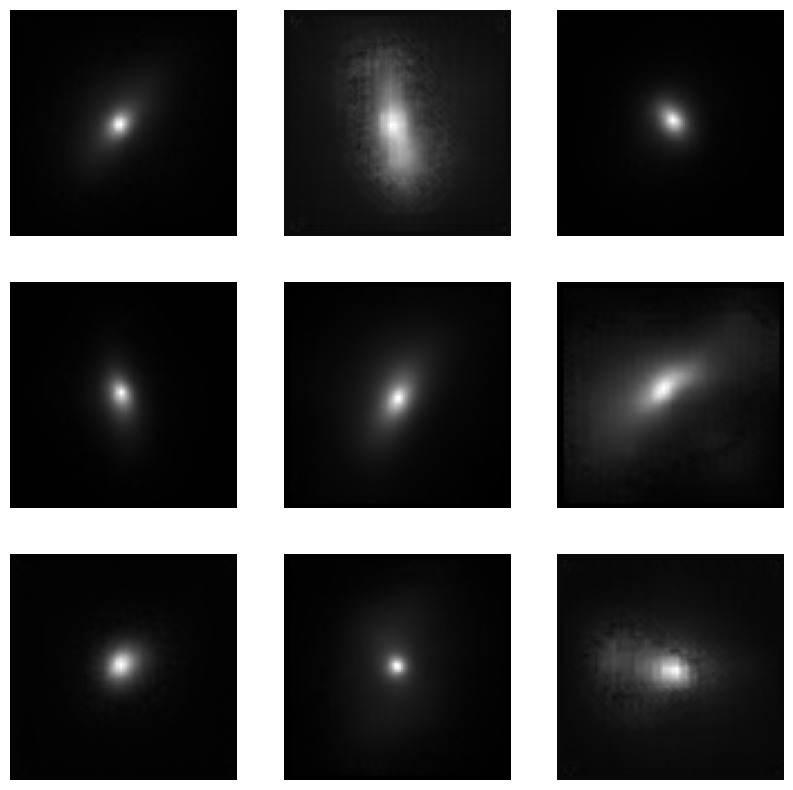

In [57]:
# And here is what each sample looks like:
figure(figsize=(10,10))
for i in range(3):
    for j in range(3):
        subplot(3,3,i+3*j+1)
        imshow(x[i+3*j],cmap='gray')
        axis('off')

Pretty cool :-) These look like galaxies

## Step V: Maximum A Posterior Solution under a data-driven prior

With this generative model in hands, we can redefine our forward model to include the morphology model in the following way:

$$y = \Pi \ast \left(  \mathbf{P} \ (\Pi_{HST}^{-1} \ast f_\theta(z) ) \right) + n \qquad \mbox{with} \qquad n \sim \mathcal{N}(0, \sigma^2)$$
where $y$ are the measurements and where:
- **$z$ is the latent variable of our forward model**, this is now the variable we are interested in inferring.
- **$f_\theta$ is the generator network of the VAE**
- $\Pi_{HST}$ is the HST PSF
- $\mathbf{P}$ is a resampling operator to go from the pixel scale of HST to that of HSC images
- $\Pi$ is a given HSC PSF
- $\sigma$ is the noise variance of HSC observations.  

Contrary to the previous section where we did not have a good prior for $x$, by construction of the generative model, we now can impose a standard Gaussian prior on $z$:

$$p(z) = \mathcal{N}(0, I)$$


**We now have all the tools for trying to perform Maximum A Posterior (MAP) inference** for our inverse problem, i.e.:

$$\hat{z} = \arg \max_{z} \log p(y | z) + \log p(z) $$

In order to achieve this, you will need to put together the following elements:

- Combine the physical forward model with generative model for an end-to-end forward model going from latent variable $z$ to HSC image.
- Write a function that computes the log posterior for a given $z$
- Use the tools from day I to do the optmization and recover a solution


In [58]:
# To keep things contained, let's redefine the likelihood function of our data here
# but this time redefined in terms of our latent variable z
def log_likelihood(z):

  # Here we use the generative model to turn z into x
  x = generative_model(z)

  # And we reuse our previous likelihood
  likelihood = tfd.Independent(tfd.Normal(simulate_hsc(x, cosmos['psf'], hsc['psf']),
                                            jnp.sqrt(hsc['variance'])),
                             reinterpreted_batch_ndims=2)
  return likelihood.log_prob(y_obs)


In [59]:
# Now we need to define the log prior on the latent variable z of our problem
def log_prior(z):
  return tfd.MultivariateNormalDiag(jnp.zeros(32),
                                    jnp.ones(32)).log_prob(z)

In [60]:
# Combining these two, we can write down the log posterior
def log_posterior(z):
  return log_likelihood(z) + log_prior(z)

In [61]:
optimizer = optax.adam(0.002)

# Create a parameter
z = jnp.zeros([32])

opt_state = optimizer.init(z)

In [62]:
@jax.jit
def update(z, opt_state):
    logp, grads = jax.value_and_grad(log_posterior)(z)
    updates, opt_state = optimizer.update(-grads, opt_state)

    # Apply gradient descent
    z = optax.apply_updates(z, updates)

    return logp, z, opt_state

In [63]:
losses = []

In [64]:
for i in range(5000):
    logp, z, opt_state = update(z, opt_state)
    losses.append(logp)

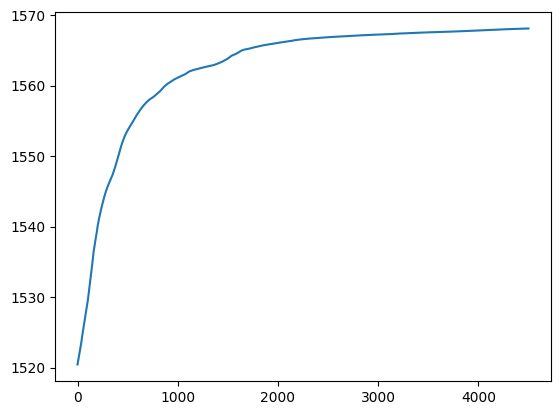

In [65]:
plot(np.array(losses)[500:])

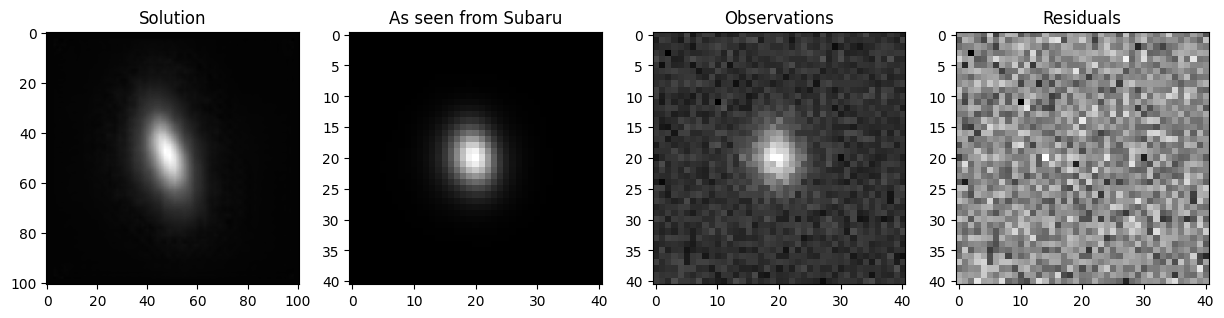

In [66]:
# Let's reconstruct x from z
x = generative_model(z)

figure(figsize=[15,5])
subplot(141)
imshow(x, cmap='gray')
title('Solution')
subplot(142)
imshow(simulate_hsc(x, cosmos['psf'], hsc['psf']), cmap='gray')
title('As seen from Subaru')
subplot(143)
imshow(y_obs, cmap='gray')
title('Observations')
subplot(144)
imshow((y_obs - simulate_hsc(x, cosmos['psf'], hsc['psf'])), cmap='gray')
title('Residuals');

How nice is that :-) Our reconstructed galaxy actually looks like a galaxy \o/


But now, let's compare it the orginal galaxy we used as an input:

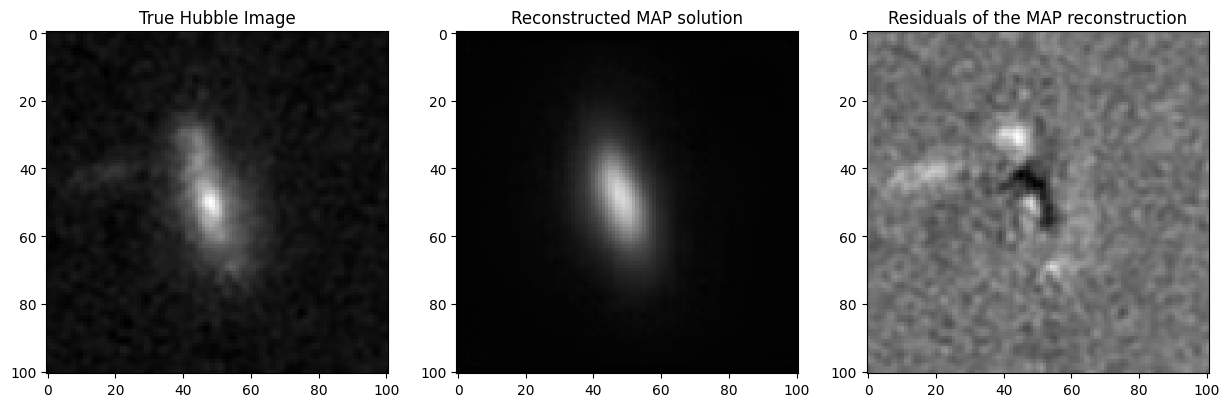

In [67]:
figure(figsize=[15,5])
subplot(131)
imshow(x_true, cmap='gray')
title('True Hubble Image')

subplot(132)
imshow(x, vmax=x_true.max(), cmap='gray')
title('Reconstructed MAP solution')

subplot(133)
imshow(x_true - x, cmap='gray')
title('Residuals of the MAP reconstruction');

As we can see, the MAP solution is not the true answer, despite providing a satisfying fit to the data and being likely under the prior.

One of the implications here, is that this reconstructed image is not the full story, **it does not tell us about the uncertainty on the solution.**

To go one step further, instead of looking for the MAP solution, we can try to sample from the full posterior distribution $p(z|y)$. Let's see how to do that in the next section.

## Step VI: Full Posterior Estimation by Variational Inference


In this final section, we will be combining everything we learned today into estimating the full posterior solution of our deconvolution problem. In other words, we now want to estimate:
$$ p (z|y) \propto p(y | z) p(z)$$

If we can estimate this posterior, it captures the full uncertainty on the solution under the specific prior assumption that we have made. However, in general, it is slow and complicated to estimate posteriors in high dimensions by traditional MCMC methods. In this tutorial, we will see how to solve the problem with much fast **Variational Inference** (VI).

The idea of VI, is to use a parametric model $q_\phi$ to approximate the posterior distribution $p(\theta | x)$. You need two things:
- a tractable and flexible parametric model $q_\phi$, we can use a Normalizing Flow for instance ;-)
- a loss function that minimizes the distance between $p$ and $q_\phi$


The loss function typically used for VI is the Evidence Lower-Bound (ELBO) (the same one as is used in a VAE ;-) ). The ELBO is the right hand side part of this expression:

$$ p_\phi(x) \geq \mathbb{E}_{\theta \sim q_\phi}\left[ \log p(x | \theta) \right] - KL(q_\phi || p) $$
where $p$ in the KL divergence term is the prior.

In other words, maximizing the ELBO tries to maximize the likelihood of the data under the model, while not going to far away from the prior $p(\theta)$.

Because it will be more suited to our case **in practice we will use this equivalent variant of the ELBO**:

$$ ELBO = \mathbb{E}_{\theta \sim q_\phi}\left[ \log p(x, \theta) \right] - \mathbb{E}_{\theta \sim q_\phi}\left[ \log q(\theta) \right]$$
It is more convenient for us because we can reuse our joint log posterior function defined in the previous step.

In [68]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tqdm
import optax
import haiku as hk
import flax.linen as nn

# Create a random sequence
rng_seq = hk.PRNGSequence(42)

class AffineCouplingLayer(nn.Module):
  @nn.compact
  def __call__(self, x, nunits):
    net = nn.leaky_relu(nn.Dense(128)(x))
    net = nn.leaky_relu(nn.Dense(128)(net))
    shift = nn.Dense(nunits)(net)
    scale = nn.softplus(nn.Dense(nunits)(net)) + 1e-3 # For numerical stability
    return  tfb.Chain([ tfb.Shift(shift), tfb.Scale(scale)])

def make_nvp_fn(n_layers=5, d=32):
  # We alternate between permutations and flow layers
  layers = [ tfb.Permute(np.arange(d)[::-1])(tfb.RealNVP(d//2,
                                            bijector_fn=AffineCouplingLayer(name='affine%d'%i)))
            for i in range(n_layers) ]

  # We build the actual nvp from these bijectors and a standard Gaussian distribution
  nvp = tfd.TransformedDistribution(
              tfd.MultivariateNormalDiag(jnp.zeros(d), jnp.ones(d)),
              bijector=tfb.Chain(layers))
  # Note that we have here added a shift and scaling to the bijector to center the posterior on the prior
  return nvp

class NeuralFlowSampler(nn.Module):
  @nn.compact
  def __call__(self,  key, n_samples):
    nvp = make_nvp_fn()
    x = nvp.sample(n_samples, seed=key)
    return x, nvp.log_prob(x)

# Let's instantiate and initialize the model
variational_posterior = NeuralFlowSampler()
params = variational_posterior.init(jax.random.PRNGKey(42), jax.random.PRNGKey(1), 32)

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/internal/backend/jax/ops.py:285: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return arr.astype(dtype)


In [69]:
# Now that we have our posterior model, we can write the elbo as a function
# of its parameters
def elbo(params, seed, n_samples=16):
  # Draw samples and their associated log probabilities from the model
  z_q, log_q = variational_posterior.apply(params, key=seed, n_samples=n_samples)

  # Write down the ELBO
  # elbo = # EXERCISE: write down the ELBO using the formula provided at the top of this section
  elbo = jnp.mean(jax.vmap(log_posterior)(z_q) - log_q)

  # we return -elbo because we will be minimizing instead of maximizing
  return - elbo

In [70]:
import optax

total_steps = 10000
lr_scheduler = optax.piecewise_constant_schedule(init_value=0.001,
                  boundaries_and_scales={int(total_steps*0.1):0.2,
                                         int(total_steps*0.6):0.1,})

optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(params)

@jax.jit
def step(params, opt_state,seed):
  loss_value, grads = jax.value_and_grad(elbo)(params,seed)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss_value
losses = []

In [71]:
for i in tqdm.tqdm(range(total_steps)):
  params, opt_state, l = step(params, opt_state, next(rng_seq))
  losses.append(l)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
100%|██████████| 10000/10000 [02:18<00:00, 72.12it/s]


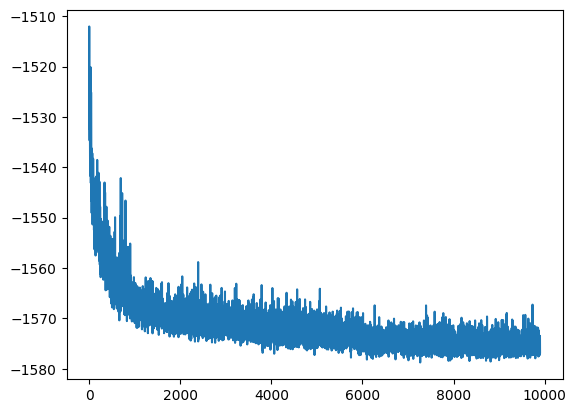

In [72]:
plot(losses[100:])

In [73]:
# Let's sample from the flow before training to see what it looks like
z, logp = variational_posterior.apply(params, key=jax.random.PRNGKey(1), n_samples=5000)

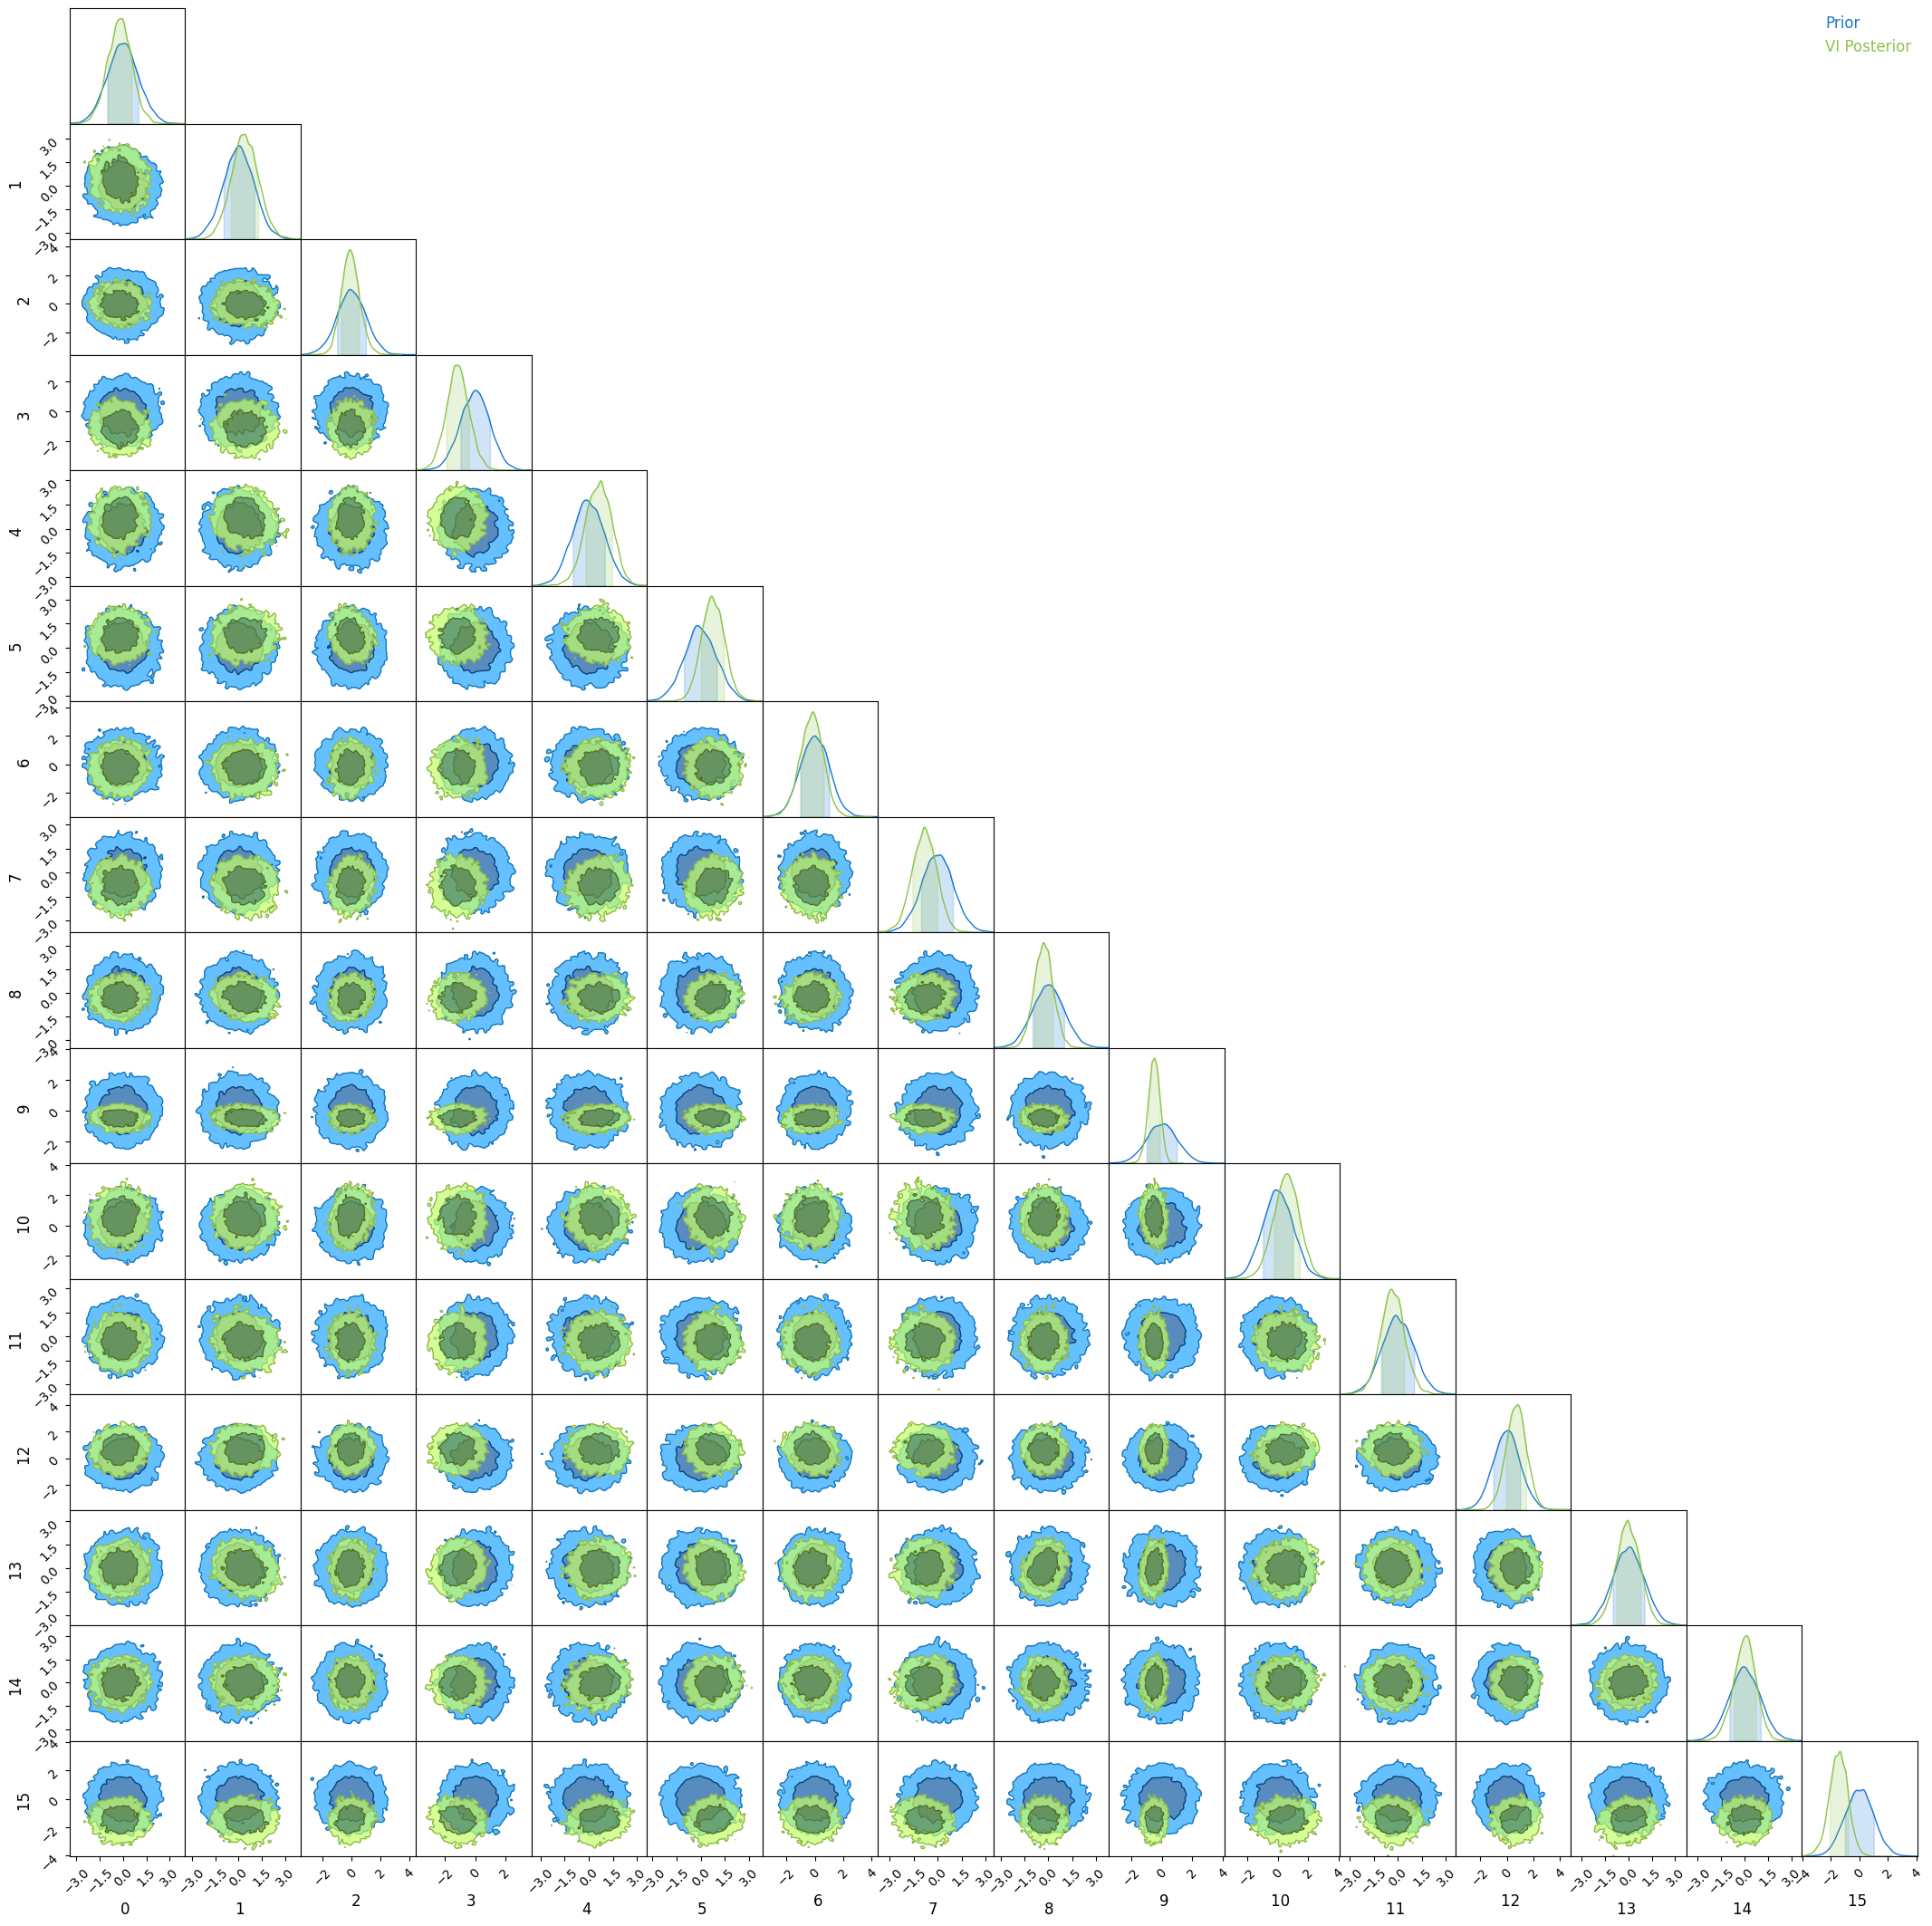

In [74]:
from chainconsumer import ChainConsumer

# We can take a look at the first 16 dimensions of our 32-d posterior
c = ChainConsumer()
c.add_chain(randn(10000, 16), name='Prior')
c.add_chain(z[:,:16], name="VI Posterior")
fig = c.configure(usetex=False).plotter.plot()

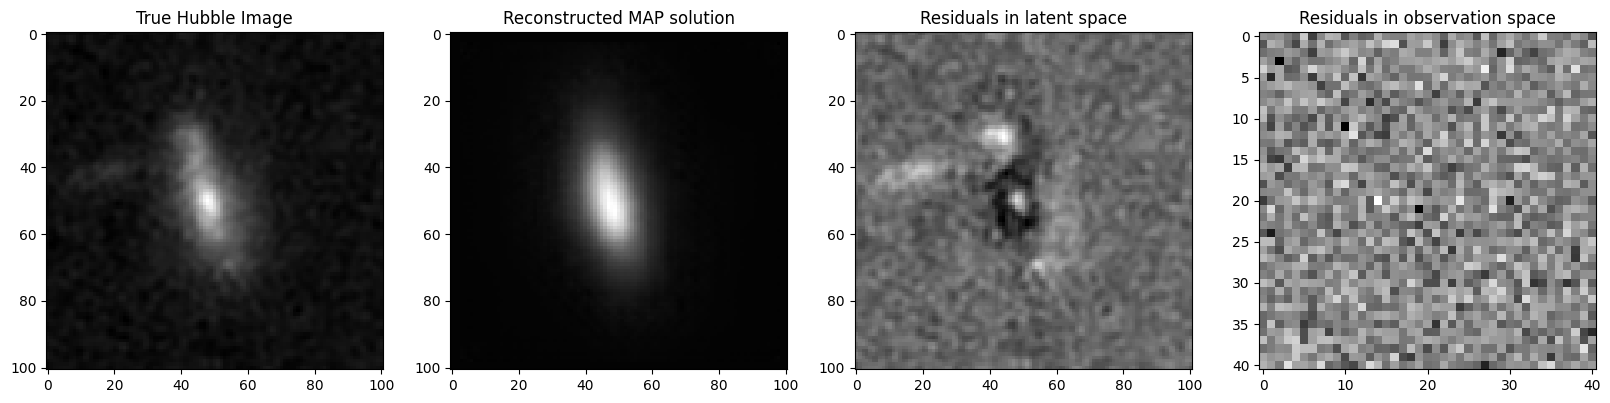

In [83]:
# But more interestingly, let's look at our posterior solutions
figure(figsize=[20,5])
subplot(141)
imshow(x_true, cmap='gray')
title('True Hubble Image')

subplot(142)
x = generative_model(z[1])
imshow(x, cmap='gray')
title('Reconstructed MAP solution')

subplot(143)
imshow(x_true - x, cmap='gray')
title('Residuals in latent space');

subplot(144)
imshow((im_noise - simulate_hsc(x, cosmos['psf'], hsc['psf'])), cmap='gray')
title('Residuals in observation space');

To help us visualize the posterio, we can also make a movie from posterior samples:

In [84]:
# The following is borrowed from https://github.com/ericjang/nf-jax/blob/master/nf-tutorial-jax.ipynb
from matplotlib import animation, rc
# from IPython.display import HTML, Image
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

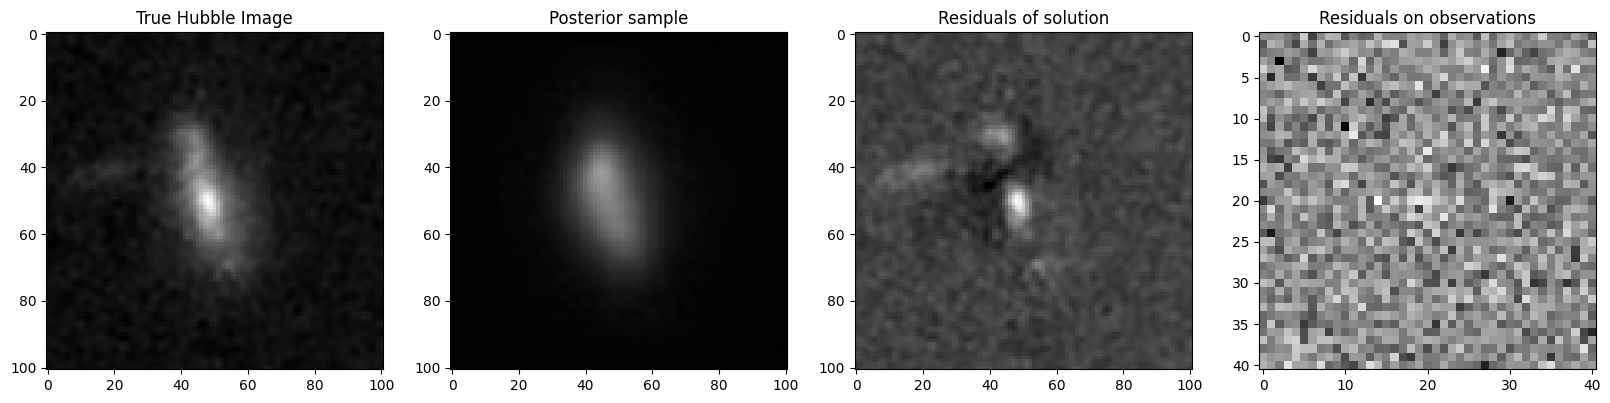

In [85]:
fig, (ax1, ax2, ax3, ax4) = subplots(1, 4, figsize=[20,5])
ax1.imshow(x_true, cmap='gray')
ax1.set_title('True Hubble Image')

x = generative_model(z[0])
im2 = ax2.imshow(x, vmax=x_true.max(), cmap='gray')
ax2.set_title('Posterior sample')

im3 = ax3.imshow(x_true - x, cmap='gray')
ax3.set_title('Residuals of solution');

im4 = ax4.imshow((y_obs - simulate_hsc(x, cosmos['psf'], hsc['psf'])), cmap='gray')
ax4.set_title('Residuals on observations');

In [86]:
def animate(i):
  x = generative_model(z[i+1])
  im2.set_data(x)
  im3.set_data(x_true - x)
  im4.set_data((y_obs - simulate_hsc(x, cosmos['psf'], hsc['psf'])))
  return (im2, im3, im4)

In [87]:
anim = animation.FuncAnimation(fig, animate, frames=100, interval=100, blit=False)

In [88]:
anim

In [89]:
# Finally, we can for instance look at the mean and standard deviation of these solutions
xs = jax.vmap(generative_model)(z[:256])

Text(0.5, 1.0, 'standard deviation')

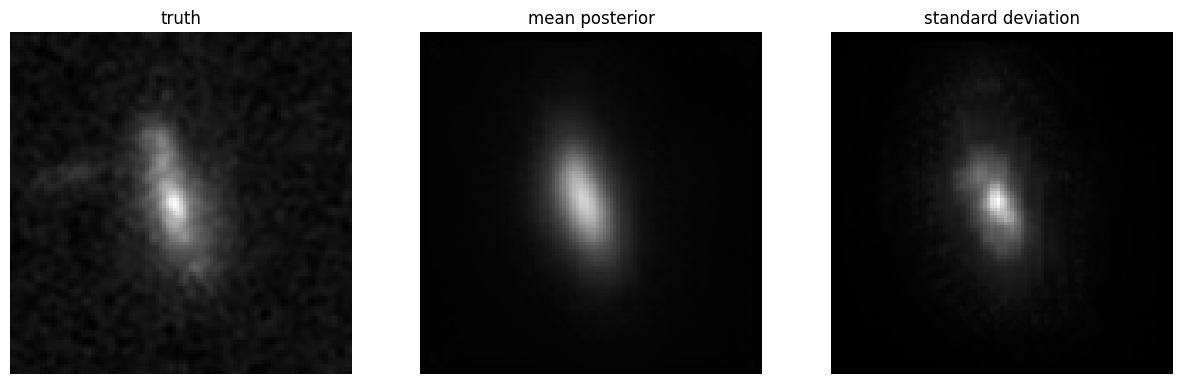

In [90]:
figure(figsize=[15,5])
subplot(131)
imshow(x_true, cmap='gray'); axis('off')
title('truth')
subplot(132)
imshow(xs.mean(axis=0),vmax=x_true.max(), cmap='gray'); axis('off')
title('mean posterior')
subplot(133)
imshow(xs.std(axis=0), cmap='gray'); axis('off')
title('standard deviation')

## [Optional]: Naive Deep Learning  Approach

Now that we have covered the basics of how to manipulate the problem, we can try a Deep Learning approach. Can a CNN recover the space-based image?

It should be noted that this is really not the approach we will try to follow in this data challenge, but this is a good opportunity to learn how to write and train a neural network in JAX.

We will use the [Haiku](https://github.com/deepmind/dm-haiku) library from DeepMind for all neural network related things.

#### Building data pipeline

Let's start with a pipeline creating examples of HST and HSC images

In [ ]:
import tensorflow as tf

def preprocess(example):
    """ Augment COSMOS dataset with random flips
    """
    x = example['image'][...,tf.newaxis]
    x = tf.image.flip_left_right(x)
    x = tf.image.flip_up_down(x)
    return {'image':x[...,0], 'psf':example['psf']}

In [ ]:
# Load COSMOS
dset_cosmos = tfds.load("Cosmos/23.5", split=tfds.Split.TRAIN,
                        data_dir='galsim/tensorflow_datasets')
dset_cosmos = dset_cosmos.cache()
dset_cosmos = dset_cosmos.repeat()
dset_cosmos = dset_cosmos.map(preprocess)
dset_cosmos = dset_cosmos.shuffle(40000)

# Load HSC
dset_hsc = tfds.load("HSC", split=tfds.Split.TRAIN,
                        data_dir='galsim/tensorflow_datasets')
dset_hsc = dset_hsc.cache()
dset_hsc = dset_hsc.repeat()
dset_hsc = dset_hsc.shuffle(10000)

# Combine both datasets
combined_dset = tf.data.Dataset.zip((dset_cosmos, dset_hsc))
combined_dset = combined_dset.batch(64)                      # Adds batching
combined_dset = combined_dset.as_numpy_iterator()

In [ ]:
batch = next(combined_dset)

In [ ]:
# A batch contains examples from both datasets
cosmos, hsc = batch

figure(figsize=[10,5])
subplot(121)
imshow(cosmos['image'][0],cmap='gray')
title('Galaxy')
subplot(122)
imshow(cosmos['psf'][0],cmap='gray')
title('PSF');

figure(figsize=[20,5])
subplot(141)
imshow(hsc['image'][0],cmap='gray')
title('Galaxy')
subplot(142)
imshow(hsc['psf'][0],cmap='gray')
title('PSF')
subplot(143)
imshow(hsc['mask'][0] == 44,cmap='gray')
title('Interpolated pixels')
subplot(144)
imshow(hsc['variance'][0],cmap='gray')
title('Variance plane');

#### Defining a Neural Network

For this kind of thing, one may think some kind of Unet might be able to solve this deconvolution task.

In Haiku, Neural Networks are defined by creating a `hk.Module` subclass and populating its `__call__` member

In [ ]:
import haiku as hk

In [ ]:
class Unet(hk.Module):
    """ The most trivial Unet possible
    """
    def __call__(self, x):
        x = hk.Conv2D(16, kernel_shape=3)(x)
        l1 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l1, window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(32, kernel_shape=3)(x)
        l2 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l2,  window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(64, kernel_shape=3)(x)
        l3 = jax.nn.leaky_relu(x)
        x = hk.avg_pool(l3, window_shape=3, strides=2, padding='SAME')

        x = hk.Conv2D(128, kernel_shape=3)(x)
        x = jax.nn.leaky_relu(x)

        x = hk.Conv2DTranspose(64, kernel_shape=3, stride=2)(x)
        x = jnp.concatenate([x, l3], axis=-1)

        x = jax.nn.leaky_relu(x)
        x = hk.Conv2DTranspose(32, kernel_shape=3, stride=2)(x)
        x = jnp.concatenate([x, l2], axis=-1)

        x = jax.nn.leaky_relu(x)
        x = hk.Conv2DTranspose(16, kernel_shape=5, stride=2)(x)
        x = jnp.concatenate([x, l1], axis=-1)

        x = hk.Conv2D(1, kernel_shape=5)(x)
        return x

In [ ]:
# Transform model into pure functions
model = hk.without_apply_rng(hk.transform(lambda x: Unet()(x)))

In [ ]:
# Initialize model parameters
params = model.init(jax.random.PRNGKey(0), jnp.zeros([1,128,128,1]))

In [ ]:
def loss_fn(params, rng, batch, return_images=False):
    # Create mock observations
    cosmos, hsc = batch

    def prep_data(cosmos, hsc):
        """ Prepares data for the neural network
        """
        obs = tfd.Independent(tfd.Normal(jax.vmap(simulate_hsc)(cosmos['image'], cosmos['psf'], hsc['psf']),
                         jnp.sqrt(hsc['variance'])),
                             reinterpreted_batch_ndims=2).sample(seed=rng)

        # Rescale obs to same pixel scale to make the life of the network easier
        x = jax.image.scale_and_translate(obs, [len(obs), 128, 128], [1,2],
                                            jnp.array([5.6, 5.6]),
                                            jnp.array([128/2 - 41/2*5.6 ,128/2 - 41/2*5.6 ]),
                                            jax.image.ResizeMethod.CUBIC)

        # Resize input and outputs for the network
        im  = jnp.pad(cosmos['image'], [[0,0], [14,13] , [14,13]])

        # Adding channel dimension
        im = jnp.expand_dims(im, -1)
        x = jnp.expand_dims(x, -1)
        return im, x, obs

    im, x, obs = prep_data(cosmos, hsc )

    # Apply neural network
    rec = model.apply(params, x)

    loss = jnp.mean( jnp.sum( (rec - im)**2, axis=[1, 2, 3]))

    if return_images:
        return im, obs, x, rec, loss
    else:
        return loss

In [ ]:
optimizer = optax.adam(0.001)
opt_state = optimizer.init(params)
rng_seq = hk.PRNGSequence(12)
losses = []

In [ ]:
@jax.jit
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    # Apply gradient descent
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [ ]:
for i in range(10000):
    batch = next(combined_dset)
    loss, params, opt_state = update(params, next(rng_seq), opt_state)
    losses.append(loss)
    if i %100 ==0:
        print('step',i,loss)

In [ ]:
loglog(losses)

In [ ]:
# Create a test dataset
dset_cosmos_test = tfds.load("Cosmos/23.5",
                        split=tfds.Split.TEST)
dset_cosmos_test = dset_cosmos_test.cache()
dset_cosmos_test = dset_cosmos_test.repeat()

dset_hsc = tfds.load("HSC",
                     split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.cache()
dset_hsc = dset_hsc.repeat()
dset_hsc = dset_hsc.shuffle(10000)

combined_dset_test = dset_hsc.zip((dset_cosmos_test , dset_hsc))
combined_dset_test = combined_dset_test.batch(64)

In [ ]:
it_test  = combined_dset_test.as_numpy_iterator()

In [ ]:
batch = next(it_test)
im, obs, y, rec, loss = loss_fn(params, next(rng_seq), batch, return_images=True)
cosmos, hsc = batch

In [ ]:
for i in range(10):
    figure(figsize=[20,5])
    subplot(141)
    imshow(im[i])
    subplot(142)
    imshow(obs[i])
    subplot(143)
    imshow(rec[i])
    subplot(144)
    # Removing the padding
    x = rec[i][14:-13:,14:-13:,0]
    x = simulate_hsc(x, cosmos['psf'][i], hsc['psf'][i])
    # Show residuals on observations
    imshow(obs[i] - x)